* Based on the Time2Vec method + the notebook/implementation from: https://github.com/cerlymarco/MEDIUM_NoteBook/blob/master/Time2Vec/Time2Vec.ipynb

* ToDo: try bilstm , try longer sequence/seasonality. 
* Com pare to simply adding in DoW, date or hour of day, or cyclic embedding of hour of day as feature(s)

In [1]:
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import random
import os

from sklearn.metrics import mean_absolute_error

import tensorflow as tf
from tensorflow import keras
from keras.layers import *
from keras.models import *
from keras.callbacks import *
from keras.optimizers import *
from keras import backend as K

# from kerashypetune import KerasGridSearch

In [2]:
### READ DATA ###

# df = pd.read_csv('Punta_Salute_2009.csv', sep=';') # orignal data had date and hour
df = pd.read_csv('./venezia.csv',parse_dates=["datetime"],infer_datetime_format=True)
# match format:
df["Data"] = df["datetime"].dt.date
df["Ora solare"] = df["datetime"].dt.hour
df.drop(["datetime"],axis=1,inplace=True, errors="ignore")
df = df.dropna()

print(df.shape)
df.head()

(289272, 3)


,level,Data,Ora solare
0,44.0,1983-01-01,1
1,35.0,1983-01-01,2
2,23.0,1983-01-01,3
3,10.0,1983-01-01,4
4,1.0,1983-01-01,5


<AxesSubplot:>

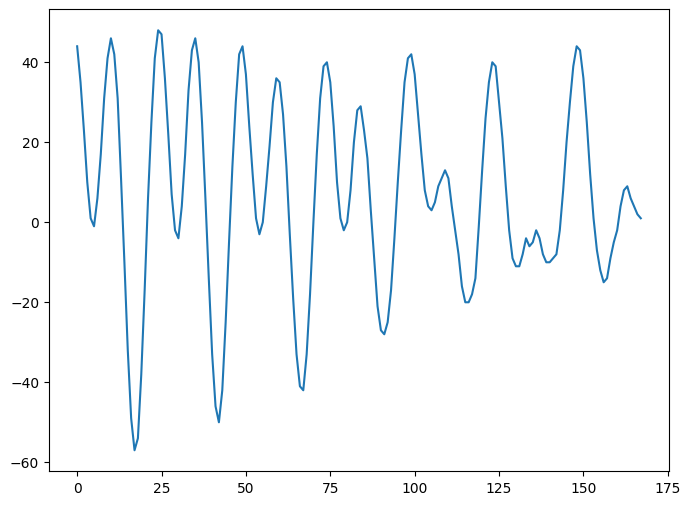

In [3]:
### PLOT WEEKLY TREND ###

df[:7*24]['level'].plot(
    y='level', x='Ora solare', figsize=(8,6))

In [21]:
### DEFINE T2V LAYER ###

class T2V(Layer):
    
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(T2V, self).__init__(**kwargs)
        
    def build(self, input_shape):

        self.W = self.add_weight(name='W',
                                shape=(input_shape[-1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.P = self.add_weight(name='P',
                                shape=(input_shape[1], self.output_dim),
                                initializer='uniform',
                                trainable=True)

        self.w = self.add_weight(name='w',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        self.p = self.add_weight(name='p',
                                shape=(input_shape[1], 1),
                                initializer='uniform',
                                trainable=True)

        super(T2V, self).build(input_shape)
        
    def call(self, x):
        
        original = self.w * x + self.p
        sin_trans = K.sin(K.dot(x, self.W) + self.P)
        
        return K.concatenate([sin_trans, original], -1)

In [5]:
### CREATE GENERATOR FOR LSTM AND T2V ###

sequence_length = 24 # orig: 24 .  note, 24*7 = 168

def gen_sequence(id_df, seq_length, seq_cols):
    
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]

    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

def gen_labels(id_df, seq_length, label):
    
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    
    return data_matrix[seq_length:num_elements, :]

In [6]:
### DEFINE MODEL STRUCTURES ###

def set_seed_TF2(seed):
    
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    

def T2V_NN(param, dim):
    
    inp = Input(shape=(dim,1))
    x = T2V(param['t2v_dim'])(inp)
    x = LSTM(param['unit'], activation=param['act'])(x)
    x = Dense(1)(x)
    
    m = Model(inp, x)
    m.compile(loss='mse', optimizer=Adam(lr=param['lr']))
    
    return m


def NN(param, dim):
    
    inp = Input(shape=(dim,1))
    x = LSTM(param['unit'], activation=param['act'])(inp)
    x = Dense(1)(x)
    
    m = Model(inp, x)
    m.compile(loss='mse', optimizer=Adam(lr=param['lr']))
    
    return m

In [15]:
### PREPARE DATA TO FEED MODELS ###

X, Y = [], []
for sequence in gen_sequence(df, sequence_length, ['level','Ora solare']):
    X.append(sequence)
    
for sequence in gen_labels(df, sequence_length, ['level','Ora solare']):
    Y.append(sequence)
    
X = np.asarray(X)
Y = np.asarray(Y)

In [16]:
X.shape

(289248, 24, 2)

In [17]:
Y.shape

(289248, 2)

In [18]:
### TRAIN TEST SPLIT ###

train_dim = int(0.7*len(df))
X_train, X_test = X[:train_dim], X[train_dim:]
y_train, y_test = Y[:train_dim], Y[train_dim:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(202490, 24, 2) (202490, 2)
(86758, 24, 2) (86758, 2)


In [19]:
### DEFINE PARAM GRID FOR HYPERPARM OPTIMIZATION ###

param_grid = {
    'unit': [64,32],
    't2v_dim': [128,64,16],
    'lr': [1e-2,1e-3], 
    'act': ['elu','relu'], 
    'epochs': 100, # 200,
    'batch_size': [128,512,1024]
}


base_param = {
    'unit': 64,
    't2v_dim': 64,
    'lr': 2e-3, 
    'act': 'relu', 
    'epochs': 100, # 200,
    'batch_size': 256
}

In [22]:
### FIT T2V + LSTM ###
### this is muc hslower if using CPU and not GPU
es = EarlyStopping(patience=3, verbose=0, min_delta=0.0005, monitor='val_loss', mode='auto', restore_best_weights=True)
### orig - hyperparam grid search
# hypermodel = lambda x: T2V_NN(param=x, dim=sequence_length)
# kgs_t2v = KerasGridSearch(hypermodel, param_grid, monitor='val_loss', greater_is_better=False, tuner_verbose=1)
# kgs_t2v.set_seed(set_seed_TF2, seed=33)
# kgs_t2v.search(X_train, y_train, validation_split=0.2, callbacks=[es], shuffle=False)
###
## new : skip search, default model
model = T2V_NN(param=base_param, dim=sequence_length)
model.fit(X_train, y_train, validation_split=0.2, callbacks=[es], shuffle=False)

# pred_t2v = kgs_t2v.best_model.predict(X_test).ravel()
pred_t2v = model.predict(X_test).ravel()
print("MAE")
mean_absolute_error(y_test.ravel(), pred_t2v)

D:\Egyetem\7.Semester\CryptoPredictions\venv\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


ValueError: in user code:

    File "D:\Egyetem\7.Semester\CryptoPredictions\venv\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "D:\Egyetem\7.Semester\CryptoPredictions\venv\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "D:\Egyetem\7.Semester\CryptoPredictions\venv\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "D:\Egyetem\7.Semester\CryptoPredictions\venv\lib\site-packages\keras\engine\training.py", line 993, in train_step
        y_pred = self(x, training=True)
    File "D:\Egyetem\7.Semester\CryptoPredictions\venv\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Marci\AppData\Local\Temp\__autograph_generated_fileotreasu8.py", line 11, in tf__call
        sin_trans = ag__.converted_call(ag__.ld(K).sin, ((ag__.converted_call(ag__.ld(K).dot, (ag__.ld(x), ag__.ld(self).W), None, fscope) + ag__.ld(self).P),), None, fscope)

    ValueError: Exception encountered when calling layer "t2v_2" "                 f"(type T2V).
    
    in user code:
    
        File "C:\Users\Marci\AppData\Local\Temp\ipykernel_14920\2700054690.py", line 36, in call  *
            sin_trans = K.sin(K.dot(x, self.W) + self.P)
        File "D:\Egyetem\7.Semester\CryptoPredictions\venv\lib\site-packages\keras\backend.py", line 2450, in dot
            tf.matmul(xt, yt), x_shape[:-1] + y_shape[:-2] + y_shape[-1:]
    
        ValueError: Dimensions must be equal, but are 2 and 1 for '{{node model_2/t2v_2/MatMul}} = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false](model_2/t2v_2/Reshape, model_2/t2v_2/Reshape_1)' with input shapes: [?,2], [1,64].
    
    
    Call arguments received by layer "t2v_2" "                 f"(type T2V):
      • x=tf.Tensor(shape=(None, 24, 2), dtype=float32)


In [14]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 1)]           0         
                                                                 
 t2v (T2V)                   (None, 24, 65)            1648      
                                                                 
 lstm (LSTM)                 (None, 64)                33280     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 34,993
Trainable params: 34,993
Non-trainable params: 0
_________________________________________________________________


In [11]:
# print("model with bigger dim")
# ## requires processing data to match new dim
# model = T2V_NN(param=base_param, dim=168) # 24*7 = 168
# model.fit(X_train, y_train, validation_split=0.2, callbacks=[es], shuffle=False)

# pred_t2v = model.predict(X_test).ravel()
# print("MAE")
# mean_absolute_error(y_test.ravel(), pred_t2v)

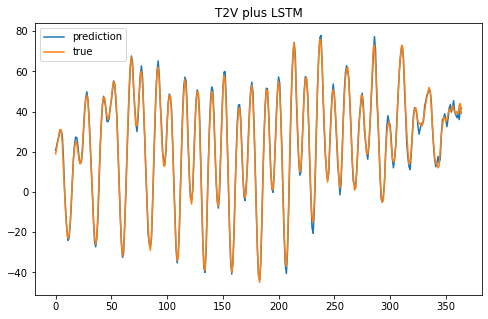

In [12]:
### VISUALIZE TEST PREDICTIONS ###

plt.figure(figsize=(8,5))

plt.plot(pred_t2v[:365], label='prediction')
plt.plot(y_test.ravel()[:365], label='true')
plt.title('T2V plus LSTM'); plt.legend()

In [13]:
### FIT SIMPLE LSTM ###

del param_grid['t2v_dim']

# es = EarlyStopping(patience=5, verbose=0, min_delta=0.001, monitor='val_loss', mode='auto', restore_best_weights=True)

# hypermodel = lambda x: NN(param=x, dim=sequence_length)
# kgs = KerasGridSearch(hypermodel, param_grid, monitor='val_loss', greater_is_better=False, tuner_verbose=1)
# kgs.set_seed(set_seed_TF2, seed=33)
# kgs.search(X_train, y_train, validation_split=0.2, callbacks=[es], shuffle=False)

kgs = NN(param=base_param, dim=sequence_length)
kgs.fit(X_train, y_train, validation_split=0.2, callbacks=[es], shuffle=False)

# pred_t2v = kgs_t2v.best_model.predict(X_test).ravel()
pred_nn = kgs.predict(X_test).ravel()
print("MAE")
mean_absolute_error(y_test.ravel(), pred_nn)

5063/5063 [==============================] - 86s 17ms/step - loss: 119.6114 - val_loss: 11.0456
MAE


2.6857143758538244

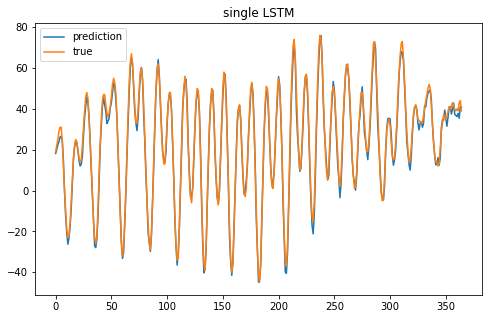

In [14]:
### VISUALIZE TEST PREDICTIONS ###

plt.figure(figsize=(8,5))

plt.plot(pred_nn[:365], label='prediction')
plt.plot(y_test.ravel()[:365], label='true')
plt.title('single LSTM'); plt.legend()